# Treatment Response Visualization and Analysis

This notebook focuses on analyzing treatment effects and identifying brain regions associated with treatment response including:
- Treatment efficacy statistical analysis
- Identification of treatment-responsive brain regions
- Responder vs non-responder pattern analysis
- Predictive features for treatment response

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

from visualization import BrainLesionVisualizer
from analysis_dashboard import BrainLesionAnalyzer

%matplotlib inline

## Initialize Analysis Tools

In [2]:
# Initialize visualizer and analyzer
data_root = Path('../data')
visualizer = BrainLesionVisualizer(data_root)
analyzer = BrainLesionAnalyzer(visualizer)

tasks_df = visualizer.tasks_df

print(f"Analysis tools initialized successfully!")
print(f"Total patients: {len(tasks_df)}")

# Filter to treatment data
treatment_data = tasks_df[
    (tasks_df['Treatment assignment'].isin(['Treatment', 'Control'])) &
    (tasks_df['Outcome score'].notna())
].copy()

treatment_data['Improvement'] = treatment_data['Clinical score'] - treatment_data['Outcome score']
treatment_data['Responder'] = treatment_data['Improvement'] > 0

print(f"Treatment analysis dataset: {len(treatment_data)} patients")
print(f"Treatment group: {len(treatment_data[treatment_data['Treatment assignment'] == 'Treatment'])}")
print(f"Control group: {len(treatment_data[treatment_data['Treatment assignment'] == 'Control'])}")

Analysis tools initialized successfully!
Total patients: 4119
Treatment analysis dataset: 1744 patients
Treatment group: 902
Control group: 842


## Treatment Efficacy Analysis

In [3]:
# Comprehensive treatment efficacy analysis
print("Performing treatment efficacy analysis...")

# Basic statistics by group
efficacy_stats = treatment_data.groupby('Treatment assignment').agg({
    'Clinical score': ['mean', 'std', 'count'],
    'Outcome score': ['mean', 'std'],
    'Improvement': ['mean', 'std'],
    'Responder': ['sum', 'mean']  # sum gives count of responders, mean gives response rate
}).round(3)

print("\nTreatment Efficacy Statistics:")
print(efficacy_stats)

# Statistical tests
treatment_improvements = treatment_data[treatment_data['Treatment assignment'] == 'Treatment']['Improvement']
control_improvements = treatment_data[treatment_data['Treatment assignment'] == 'Control']['Improvement']

# T-test for improvement differences
t_stat, t_pvalue = stats.ttest_ind(treatment_improvements, control_improvements)
print(f"\nT-test for improvement differences:")
print(f"t-statistic: {t_stat:.3f}, p-value: {t_pvalue:.4f}")

# Mann-Whitney U test (non-parametric)
u_stat, u_pvalue = stats.mannwhitneyu(treatment_improvements, control_improvements, alternative='two-sided')
print(f"\nMann-Whitney U test:")
print(f"U-statistic: {u_stat:.3f}, p-value: {u_pvalue:.4f}")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(treatment_improvements) - 1) * treatment_improvements.var() + 
                     (len(control_improvements) - 1) * control_improvements.var()) / 
                    (len(treatment_improvements) + len(control_improvements) - 2))
cohens_d = (treatment_improvements.mean() - control_improvements.mean()) / pooled_std
print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")

# Response rate comparison
treatment_response_rate = (treatment_improvements > 0).mean()
control_response_rate = (control_improvements > 0).mean()

print(f"\nResponse Rates:")
print(f"Treatment: {treatment_response_rate:.2%}")
print(f"Control: {control_response_rate:.2%}")

# Chi-square test for response rates
treatment_responders = (treatment_improvements > 0).sum()
control_responders = (control_improvements > 0).sum()
contingency_table = np.array([
    [treatment_responders, len(treatment_improvements) - treatment_responders],
    [control_responders, len(control_improvements) - control_responders]
])
chi2, chi2_p = stats.chi2_contingency(contingency_table)[:2]
print(f"\nChi-square test for response rates:")
print(f"Chi-square: {chi2:.3f}, p-value: {chi2_p:.4f}")

Performing treatment efficacy analysis...

Treatment Efficacy Statistics:
                     Clinical score               Outcome score          \
                               mean     std count          mean     std   
Treatment assignment                                                      
Control                       9.502  13.597   842         9.506  13.713   
Treatment                     9.963  14.062   902         9.479  14.165   

                     Improvement        Responder         
                            mean    std       sum   mean  
Treatment assignment                                      
Control                   -0.004  1.542       138  0.164  
Treatment                  0.484  2.028       300  0.333  

T-test for improvement differences:
t-statistic: 5.628, p-value: 0.0000

Mann-Whitney U test:
U-statistic: 446502.000, p-value: 0.0000

Effect size (Cohen's d): 0.270

Response Rates:
Treatment: 33.26%
Control: 16.39%

Chi-square test for response rates:

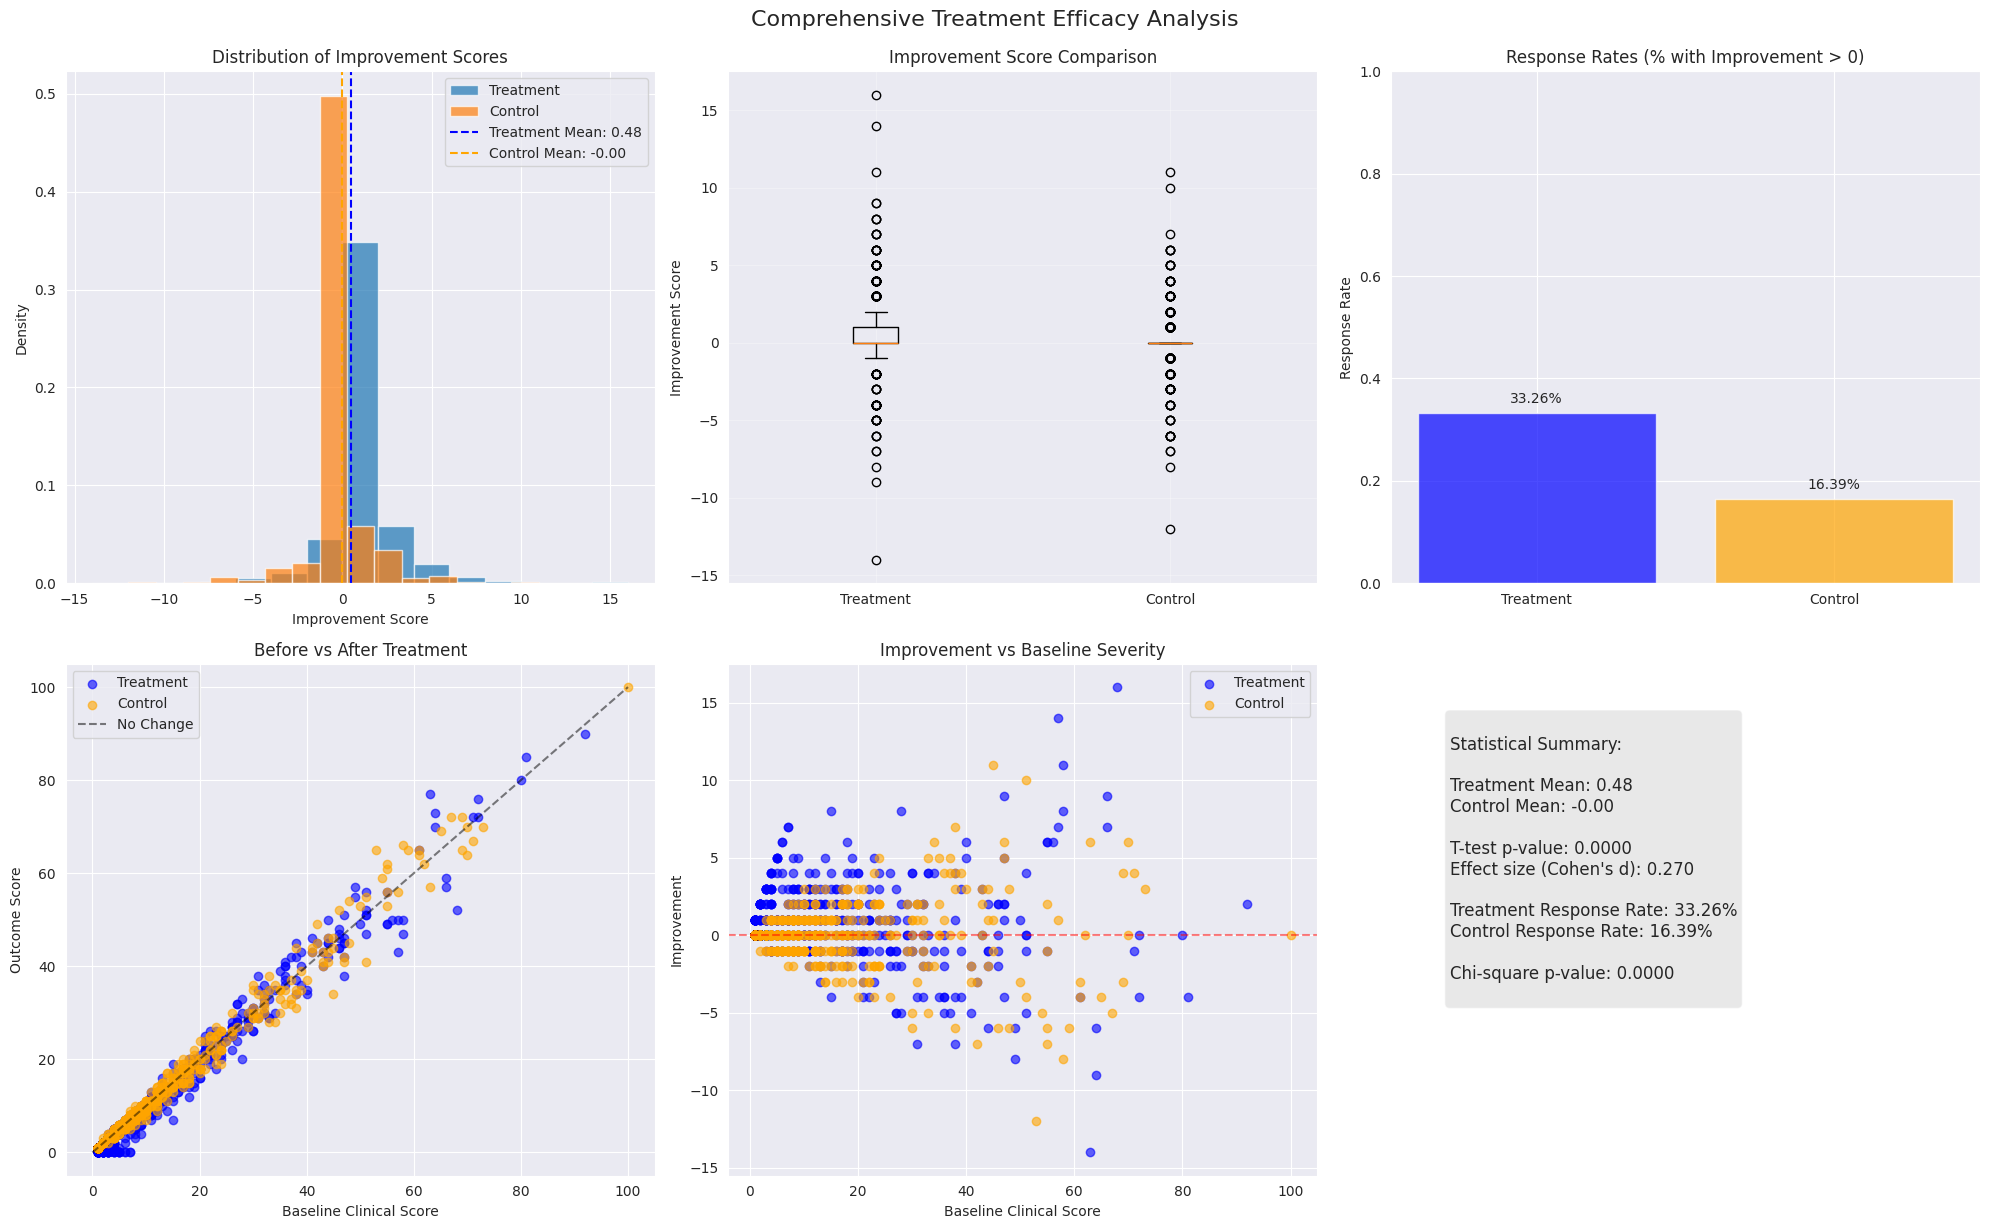

In [4]:
# Comprehensive treatment effect visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Improvement distribution
axes[0,0].hist(treatment_improvements, bins=15, alpha=0.7, label='Treatment', density=True)
axes[0,0].hist(control_improvements, bins=15, alpha=0.7, label='Control', density=True)
axes[0,0].axvline(treatment_improvements.mean(), color='blue', linestyle='--', label=f'Treatment Mean: {treatment_improvements.mean():.2f}')
axes[0,0].axvline(control_improvements.mean(), color='orange', linestyle='--', label=f'Control Mean: {control_improvements.mean():.2f}')
axes[0,0].set_xlabel('Improvement Score')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Distribution of Improvement Scores')
axes[0,0].legend()

# 2. Box plot comparison
improvement_data = [treatment_improvements, control_improvements]
axes[0,1].boxplot(improvement_data, labels=['Treatment', 'Control'])
axes[0,1].set_ylabel('Improvement Score')
axes[0,1].set_title('Improvement Score Comparison')
axes[0,1].grid(True, alpha=0.3)

# 3. Response rates
response_rates = [treatment_response_rate, control_response_rate]
axes[0,2].bar(['Treatment', 'Control'], response_rates, color=['blue', 'orange'], alpha=0.7)
axes[0,2].set_ylabel('Response Rate')
axes[0,2].set_title('Response Rates (% with Improvement > 0)')
axes[0,2].set_ylim(0, 1)
for i, rate in enumerate(response_rates):
    axes[0,2].text(i, rate + 0.02, f'{rate:.2%}', ha='center')

# 4. Before vs After scatter
treatment_subset = treatment_data[treatment_data['Treatment assignment'] == 'Treatment']
control_subset = treatment_data[treatment_data['Treatment assignment'] == 'Control']

axes[1,0].scatter(treatment_subset['Clinical score'], treatment_subset['Outcome score'], 
                 alpha=0.6, label='Treatment', color='blue')
axes[1,0].scatter(control_subset['Clinical score'], control_subset['Outcome score'], 
                 alpha=0.6, label='Control', color='orange')

# Add diagonal line (no change)
max_score = max(treatment_data['Clinical score'].max(), treatment_data['Outcome score'].max())
axes[1,0].plot([0, max_score], [0, max_score], 'k--', alpha=0.5, label='No Change')
axes[1,0].set_xlabel('Baseline Clinical Score')
axes[1,0].set_ylabel('Outcome Score')
axes[1,0].set_title('Before vs After Treatment')
axes[1,0].legend()

# 5. Improvement by baseline severity
axes[1,1].scatter(treatment_subset['Clinical score'], treatment_subset['Improvement'], 
                 alpha=0.6, label='Treatment', color='blue')
axes[1,1].scatter(control_subset['Clinical score'], control_subset['Improvement'], 
                 alpha=0.6, label='Control', color='orange')
axes[1,1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1,1].set_xlabel('Baseline Clinical Score')
axes[1,1].set_ylabel('Improvement')
axes[1,1].set_title('Improvement vs Baseline Severity')
axes[1,1].legend()

# 6. Statistical summary
axes[1,2].axis('off')
stats_text = f"""
Statistical Summary:

Treatment Mean: {treatment_improvements.mean():.2f}
Control Mean: {control_improvements.mean():.2f}

T-test p-value: {t_pvalue:.4f}
Effect size (Cohen's d): {cohens_d:.3f}

Treatment Response Rate: {treatment_response_rate:.2%}
Control Response Rate: {control_response_rate:.2%}

Chi-square p-value: {chi2_p:.4f}
"""
axes[1,2].text(0.1, 0.9, stats_text, transform=axes[1,2].transAxes, fontsize=12, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.suptitle('Comprehensive Treatment Efficacy Analysis', fontsize=16, y=1.02)
plt.show()

## Responsive Brain Region Analysis

In [5]:
# Analyze brain regions associated with treatment response
print("Analyzing treatment-responsive brain regions...")
print("This analysis compares lesion patterns between responders and non-responders in the treatment group")

# Focus on treatment group only for response analysis
treatment_only = treatment_data[treatment_data['Treatment assignment'] == 'Treatment'].copy()

# Define responders vs non-responders
min_improvement = 5.0  # You can adjust this threshold
treatment_only['Strong_Responder'] = treatment_only['Improvement'] >= min_improvement

responders = treatment_only[treatment_only['Strong_Responder']]
non_responders = treatment_only[~treatment_only['Strong_Responder']]

print(f"\nUsing improvement threshold of {min_improvement} points:")
print(f"Strong responders: {len(responders)}")
print(f"Non-responders: {len(non_responders)}")
print(f"Overall response rate: {len(responders)/len(treatment_only):.2%}")

if len(responders) > 3 and len(non_responders) > 3:
    # Sample for computational efficiency
    responder_sample = responders.sample(n=min(15, len(responders)), random_state=42)
    non_responder_sample = non_responders.sample(n=min(15, len(non_responders)), random_state=42)
    
    # Load lesion data for both groups
    print(f"\nLoading lesion data for {len(responder_sample)} responders and {len(non_responder_sample)} non-responders...")
    
    responder_map = np.zeros((91, 109, 91))
    non_responder_map = np.zeros((91, 109, 91))
    
    responder_count = 0
    for _, row in responder_sample.iterrows():
        try:
            lesion_data = visualizer.load_lesion(row['lesion_id'])
            responder_map += lesion_data
            responder_count += 1
        except FileNotFoundError:
            continue
    
    non_responder_count = 0
    for _, row in non_responder_sample.iterrows():
        try:
            lesion_data = visualizer.load_lesion(row['lesion_id'])
            non_responder_map += lesion_data
            non_responder_count += 1
        except FileNotFoundError:
            continue
    
    print(f"Loaded data for {responder_count} responders and {non_responder_count} non-responders")
    
    if responder_count > 0 and non_responder_count > 0:
        # Normalize to frequencies
        responder_freq = responder_map / responder_count
        non_responder_freq = non_responder_map / non_responder_count
        
        # Calculate difference map
        difference_map = responder_freq - non_responder_freq
        
        print(f"Analysis completed successfully!")
        print(f"Max frequency in responders: {np.max(responder_freq):.3f}")
        print(f"Max frequency in non-responders: {np.max(non_responder_freq):.3f}")
        print(f"Max positive difference: {np.max(difference_map):.3f}")
        print(f"Max negative difference: {np.min(difference_map):.3f}")
        
        response_analysis_successful = True
        
    else:
        print("Failed to load sufficient lesion data")
        response_analysis_successful = False
else:
    print("Insufficient responders or non-responders for analysis")
    response_analysis_successful = False

Analyzing treatment-responsive brain regions...
This analysis compares lesion patterns between responders and non-responders in the treatment group

Using improvement threshold of 5.0 points:
Strong responders: 31
Non-responders: 871
Overall response rate: 3.44%

Loading lesion data for 15 responders and 15 non-responders...
Loaded data for 15 responders and 15 non-responders
Analysis completed successfully!
Max frequency in responders: 0.400
Max frequency in non-responders: 0.267
Max positive difference: 0.333
Max negative difference: -0.200


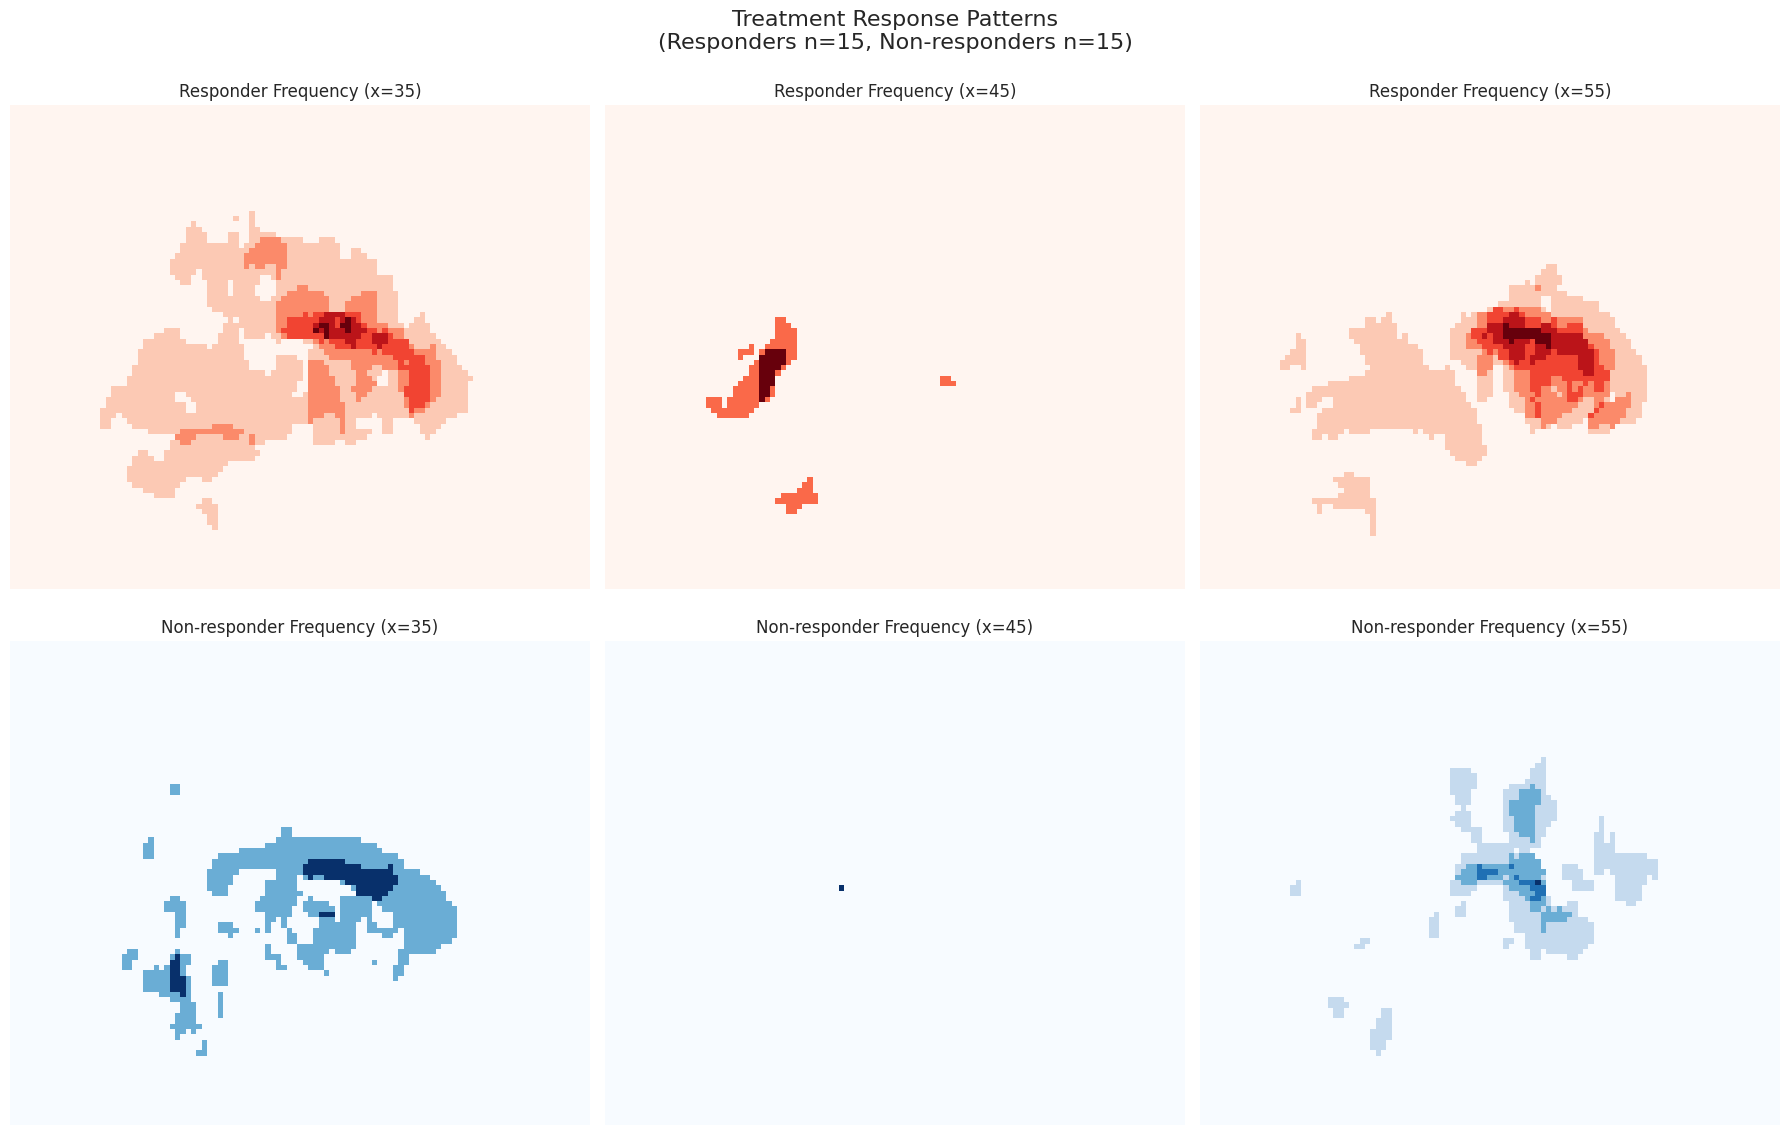

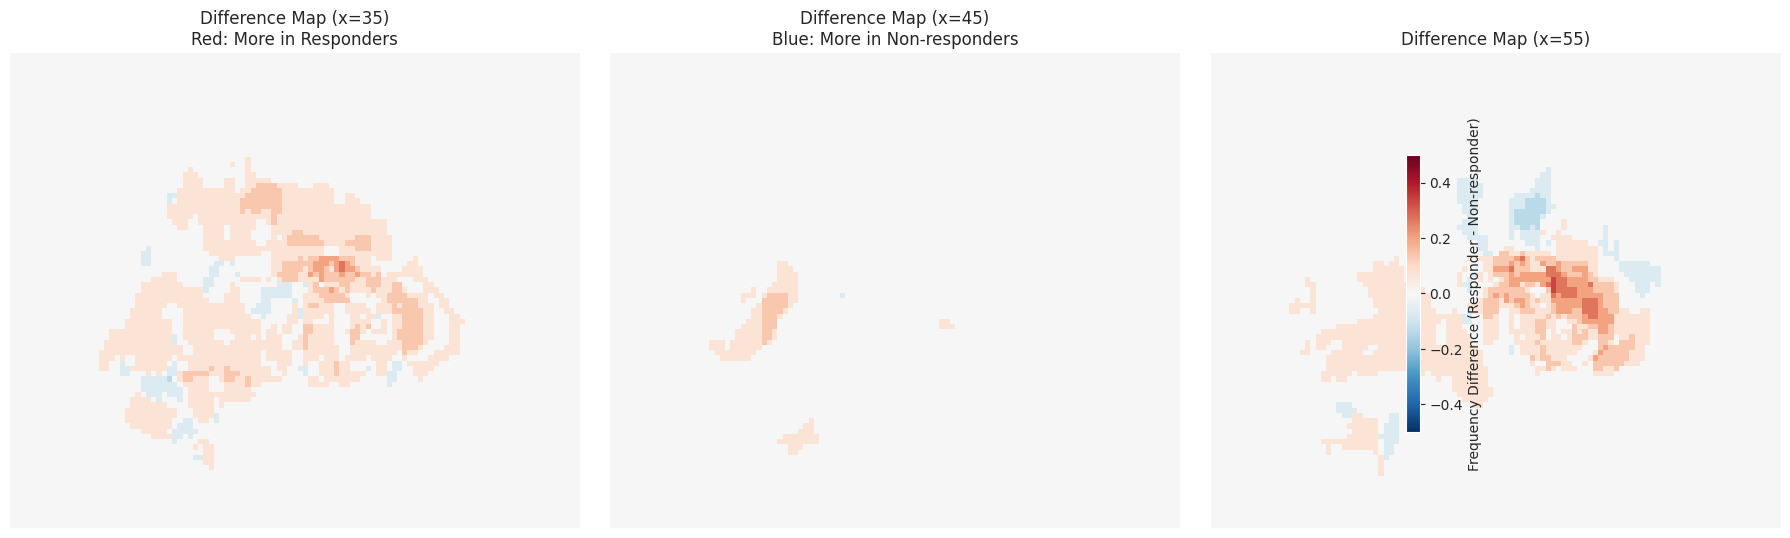

In [6]:
# Visualize responsive regions
if response_analysis_successful:
    # Select sagittal slices for visualization
    center_x = difference_map.shape[0] // 2
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Responder frequency maps
    axes[0,0].imshow(responder_freq[center_x-10, :, :].T, cmap='Reds', origin='lower')
    axes[0,0].set_title(f'Responder Frequency (x={center_x-10})')
    axes[0,0].axis('off')
    
    axes[0,1].imshow(responder_freq[center_x, :, :].T, cmap='Reds', origin='lower')
    axes[0,1].set_title(f'Responder Frequency (x={center_x})')
    axes[0,1].axis('off')
    
    axes[0,2].imshow(responder_freq[center_x+10, :, :].T, cmap='Reds', origin='lower')
    axes[0,2].set_title(f'Responder Frequency (x={center_x+10})')
    axes[0,2].axis('off')
    
    # Non-responder frequency maps
    axes[1,0].imshow(non_responder_freq[center_x-10, :, :].T, cmap='Blues', origin='lower')
    axes[1,0].set_title(f'Non-responder Frequency (x={center_x-10})')
    axes[1,0].axis('off')
    
    axes[1,1].imshow(non_responder_freq[center_x, :, :].T, cmap='Blues', origin='lower')
    axes[1,1].set_title(f'Non-responder Frequency (x={center_x})')
    axes[1,1].axis('off')
    
    axes[1,2].imshow(non_responder_freq[center_x+10, :, :].T, cmap='Blues', origin='lower')
    axes[1,2].set_title(f'Non-responder Frequency (x={center_x+10})')
    axes[1,2].axis('off')
    
    plt.suptitle(f'Treatment Response Patterns\n(Responders n={responder_count}, Non-responders n={non_responder_count})', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Difference map visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Show difference maps
    im1 = axes[0].imshow(difference_map[center_x-10, :, :].T, cmap='RdBu_r', origin='lower', vmin=-0.5, vmax=0.5)
    axes[0].set_title(f'Difference Map (x={center_x-10})\nRed: More in Responders')
    axes[0].axis('off')
    
    im2 = axes[1].imshow(difference_map[center_x, :, :].T, cmap='RdBu_r', origin='lower', vmin=-0.5, vmax=0.5)
    axes[1].set_title(f'Difference Map (x={center_x})\nBlue: More in Non-responders')
    axes[1].axis('off')
    
    im3 = axes[2].imshow(difference_map[center_x+10, :, :].T, cmap='RdBu_r', origin='lower', vmin=-0.5, vmax=0.5)
    axes[2].set_title(f'Difference Map (x={center_x+10})')
    axes[2].axis('off')
    
    # Add colorbar
    plt.colorbar(im2, ax=axes, shrink=0.6, label='Frequency Difference (Responder - Non-responder)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot visualize responsive regions - insufficient data")

## Predictive Analysis for Treatment Response

In [7]:
# Create predictive features for treatment response
print("Creating predictive features for treatment response...")

# Use treatment group only
treatment_group = treatment_data[treatment_data['Treatment assignment'] == 'Treatment'].copy()

if len(treatment_group) > 10:
    # Sample for efficiency
    analysis_sample = treatment_group.sample(n=min(50, len(treatment_group)), random_state=42)
    
    # Calculate features for each patient
    features = []
    labels = []
    valid_patients = []
    
    print(f"Processing {len(analysis_sample)} patients for predictive analysis...")
    
    for _, row in analysis_sample.iterrows():
        try:
            lesion_data = visualizer.load_lesion(row['lesion_id'])
            
            # Calculate various lesion features
            total_volume = np.sum(lesion_data)
            
            # Regional volumes (simplified regions)
            frontal_volume = np.sum(lesion_data[:30, :, :])
            parietal_volume = np.sum(lesion_data[30:60, :, :])
            occipital_volume = np.sum(lesion_data[60:, :, :])
            
            # Vertical distribution
            superior_volume = np.sum(lesion_data[:, :, 60:])
            middle_volume = np.sum(lesion_data[:, :, 30:60])
            inferior_volume = np.sum(lesion_data[:, :, :30])
            
            # Lesion compactness (rough measure)
            if total_volume > 0:
                coords = np.where(lesion_data > 0)
                center_of_mass = [np.mean(coords[i]) for i in range(3)]
                distances = [np.sqrt(sum([(coords[i][j] - center_of_mass[i])**2 for i in range(3)])) 
                            for j in range(len(coords[0]))]
                compactness = np.std(distances) if len(distances) > 1 else 0
            else:
                compactness = 0
            
            # Combine features
            patient_features = [
                row['Clinical score'],  # Baseline severity
                total_volume,
                frontal_volume / total_volume if total_volume > 0 else 0,
                parietal_volume / total_volume if total_volume > 0 else 0,
                occipital_volume / total_volume if total_volume > 0 else 0,
                superior_volume / total_volume if total_volume > 0 else 0,
                middle_volume / total_volume if total_volume > 0 else 0,
                inferior_volume / total_volume if total_volume > 0 else 0,
                compactness
            ]
            
            features.append(patient_features)
            labels.append(row['Improvement'] > 0)  # Binary response
            valid_patients.append(row)
            
        except FileNotFoundError:
            continue
    
    print(f"Features calculated for {len(features)} patients")
    
    if len(features) > 10:
        X = np.array(features)
        y = np.array(labels)
        
        feature_names = [
            'Clinical Score', 'Total Volume', 'Frontal %', 'Parietal %', 'Occipital %',
            'Superior %', 'Middle %', 'Inferior %', 'Compactness'
        ]
        
        # Create feature dataframe for analysis
        feature_df = pd.DataFrame(X, columns=feature_names)
        feature_df['Response'] = y
        
        print(f"\nResponse rate in analysis sample: {np.mean(y):.2%}")
        
        predictive_analysis_successful = True
        
    else:
        print("Insufficient data for predictive analysis")
        predictive_analysis_successful = False
        
else:
    print("Insufficient treatment group data")
    predictive_analysis_successful = False

Creating predictive features for treatment response...
Processing 50 patients for predictive analysis...
Features calculated for 50 patients

Response rate in analysis sample: 30.00%


Analyzing predictive features...

Feature comparison (Responders vs Non-responders):
Clinical Score: Resp=17.333, Non-resp=10.343, p=0.152
Total Volume: Resp=5424.800, Non-resp=3090.171, p=0.151
Frontal %: Resp=0.273, Non-resp=0.159, p=0.288
Parietal %: Resp=0.397, Non-resp=0.572, p=0.114
Occipital %: Resp=0.330, Non-resp=0.269, p=0.573
Superior %: Resp=0.024, Non-resp=0.057, p=0.313
Middle %: Resp=0.896, Non-resp=0.827, p=0.385
Inferior %: Resp=0.081, Non-resp=0.116, p=0.652
Compactness: Resp=4.654, Non-resp=3.974, p=0.242


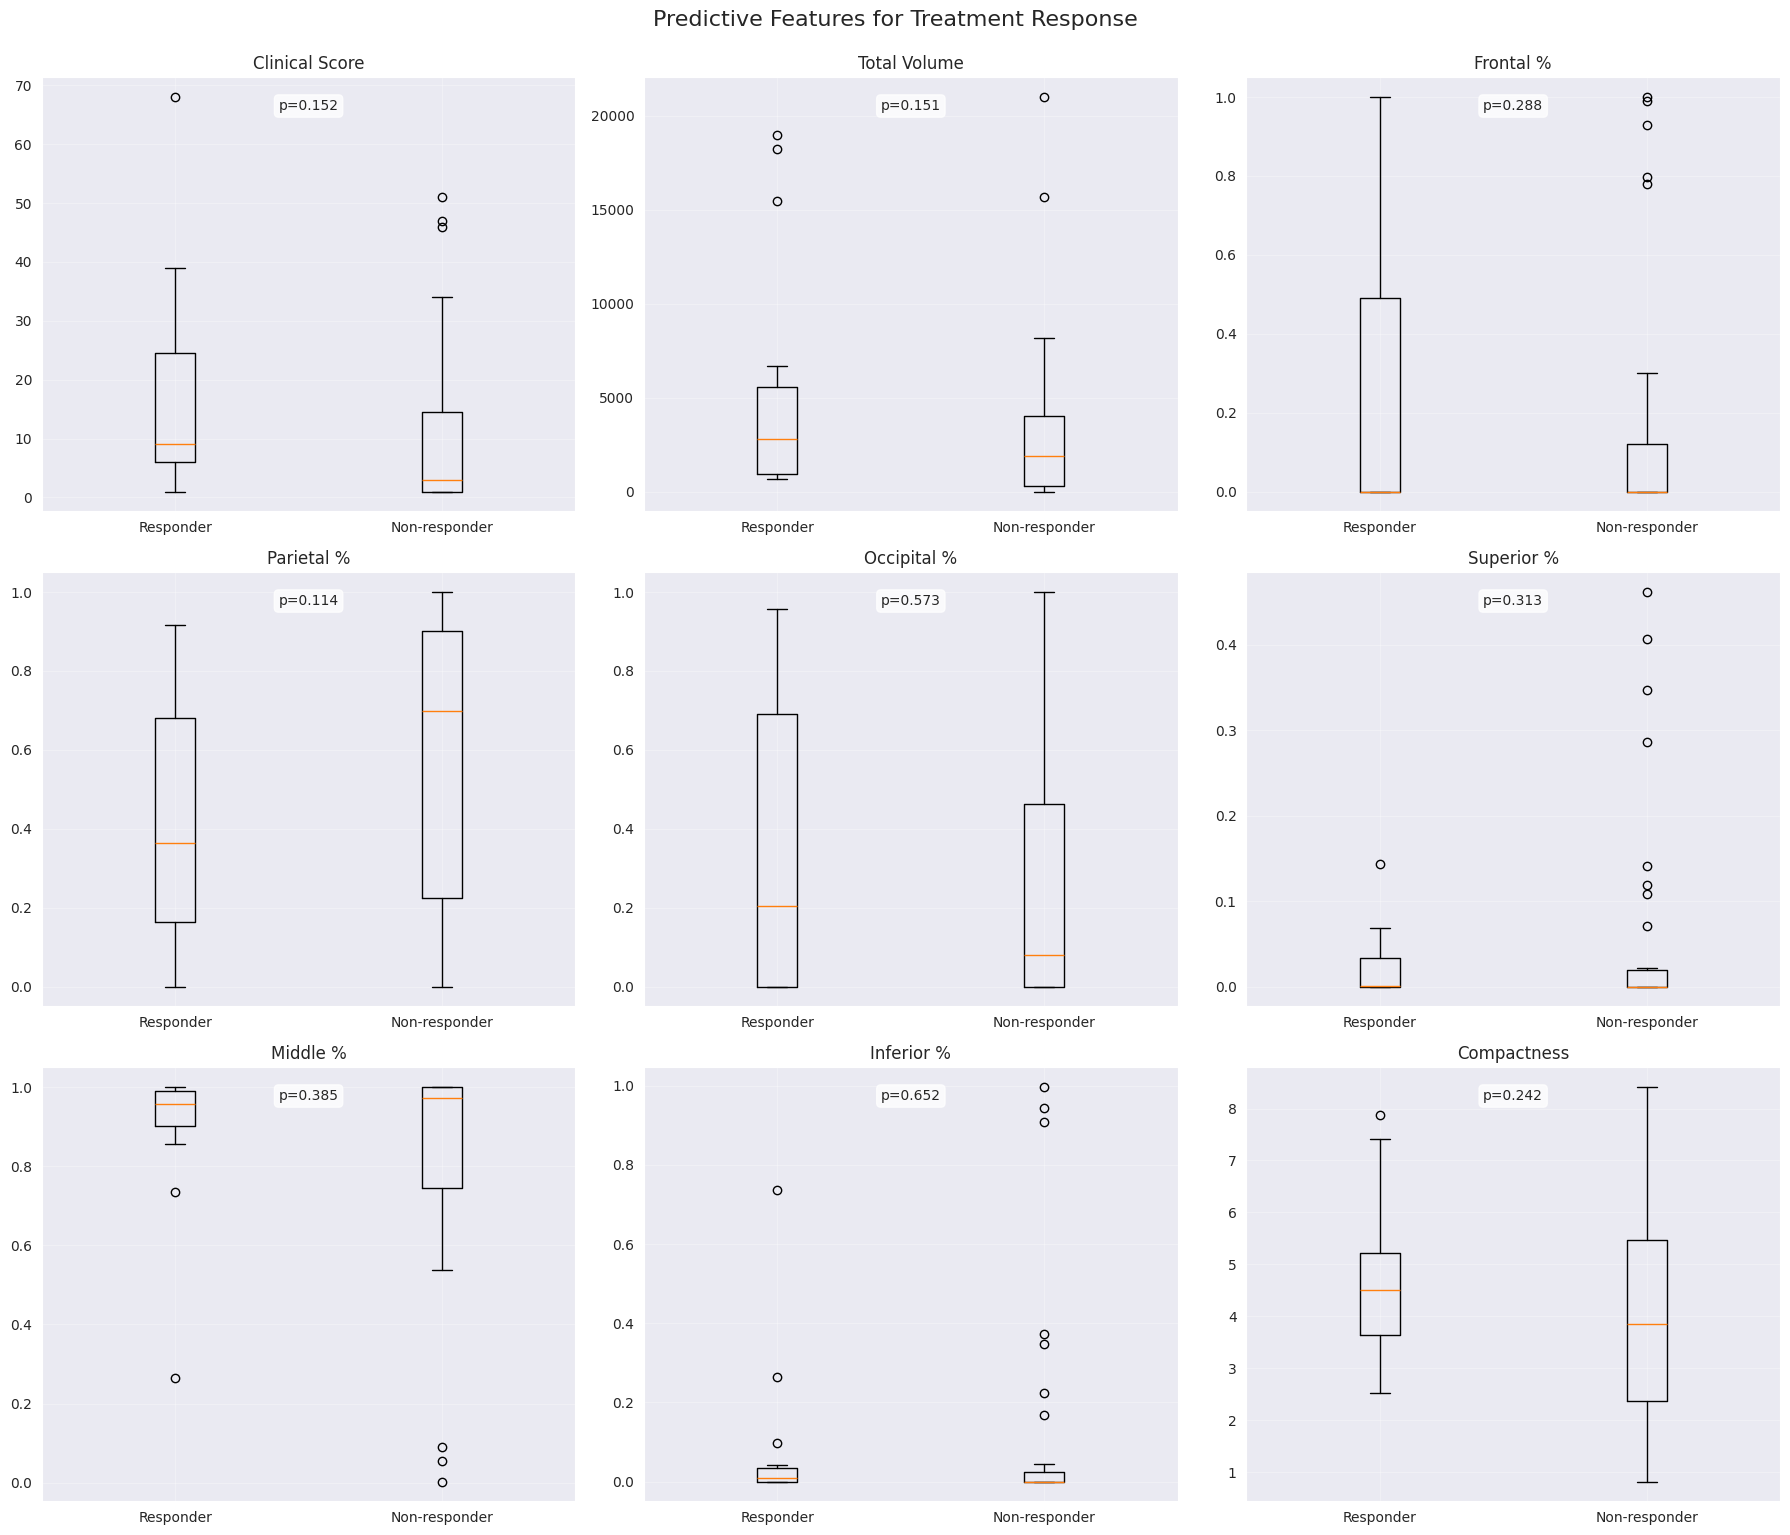

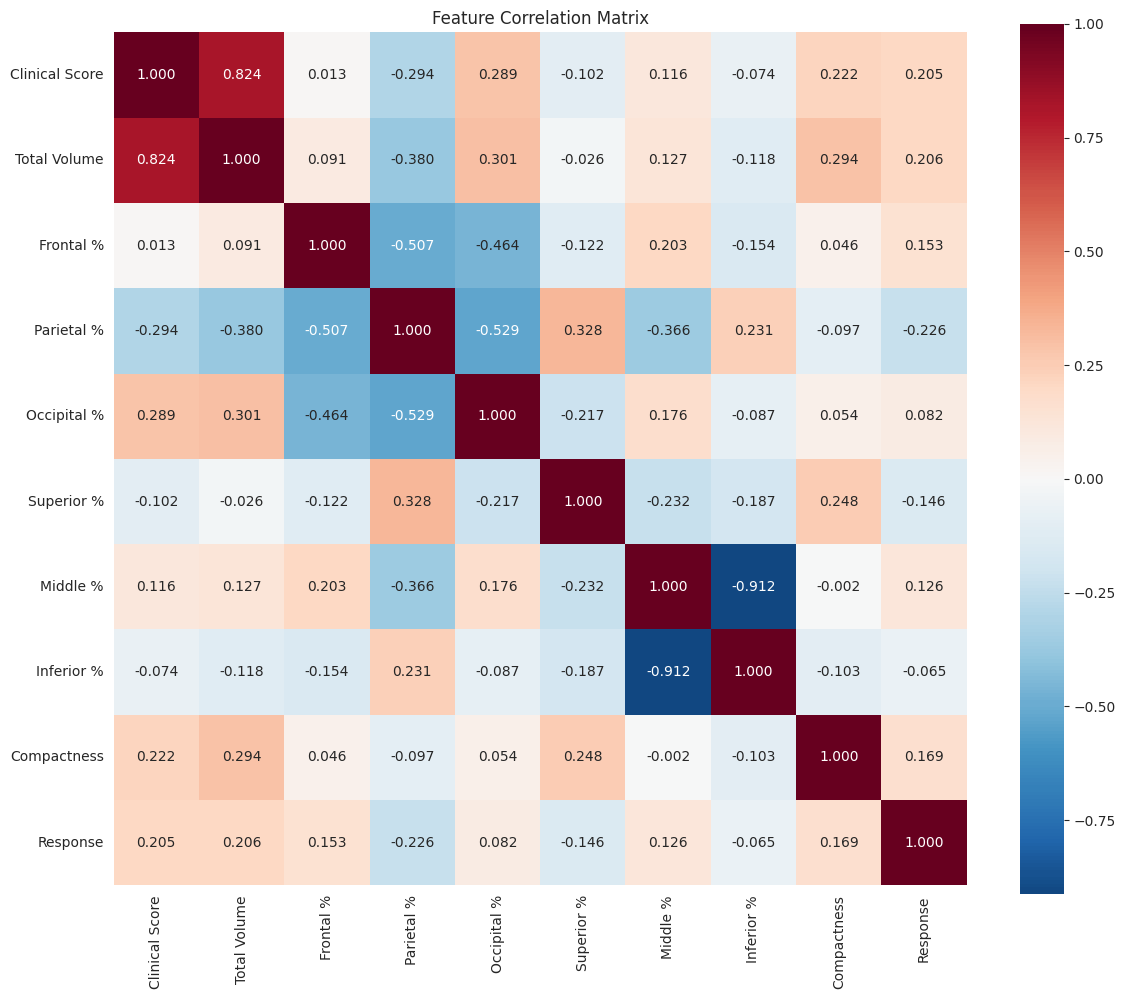

In [8]:
# Analyze predictive features
if predictive_analysis_successful:
    # Feature analysis
    print("Analyzing predictive features...")
    
    # Compare features between responders and non-responders
    responder_features = feature_df[feature_df['Response'] == True]
    non_responder_features = feature_df[feature_df['Response'] == False]
    
    print(f"\nFeature comparison (Responders vs Non-responders):")
    for feature in feature_names:
        resp_mean = responder_features[feature].mean()
        non_resp_mean = non_responder_features[feature].mean()
        
        # T-test for difference
        if len(responder_features) > 1 and len(non_responder_features) > 1:
            t_stat, p_val = stats.ttest_ind(responder_features[feature], non_responder_features[feature])
            print(f"{feature}: Resp={resp_mean:.3f}, Non-resp={non_resp_mean:.3f}, p={p_val:.3f}")
    
    # Visualize feature differences
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()
    
    for i, feature in enumerate(feature_names):
        # Box plot for each feature
        resp_data = responder_features[feature]
        non_resp_data = non_responder_features[feature]
        
        axes[i].boxplot([resp_data, non_resp_data], labels=['Responder', 'Non-responder'])
        axes[i].set_title(f'{feature}')
        axes[i].grid(True, alpha=0.3)
        
        # Add statistical test result
        if len(resp_data) > 1 and len(non_resp_data) > 1:
            _, p_val = stats.ttest_ind(resp_data, non_resp_data)
            axes[i].text(0.5, 0.95, f'p={p_val:.3f}', transform=axes[i].transAxes, 
                        ha='center', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('Predictive Features for Treatment Response', fontsize=16, y=1.02)
    plt.show()
    
    # Feature correlation analysis
    plt.figure(figsize=(12, 10))
    correlation_matrix = feature_df[feature_names + ['Response']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.3f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot perform predictive analysis - insufficient data")

Building predictive model for treatment response...
Cross-validation accuracy: 0.640 ± 0.080

Feature Importance for Treatment Response:
          feature  importance
1    Total Volume    0.236258
6        Middle %    0.148781
8     Compactness    0.140504
0  Clinical Score    0.130969
3      Parietal %    0.117217
4     Occipital %    0.066476
5      Superior %    0.056952
7      Inferior %    0.052864
2       Frontal %    0.049979


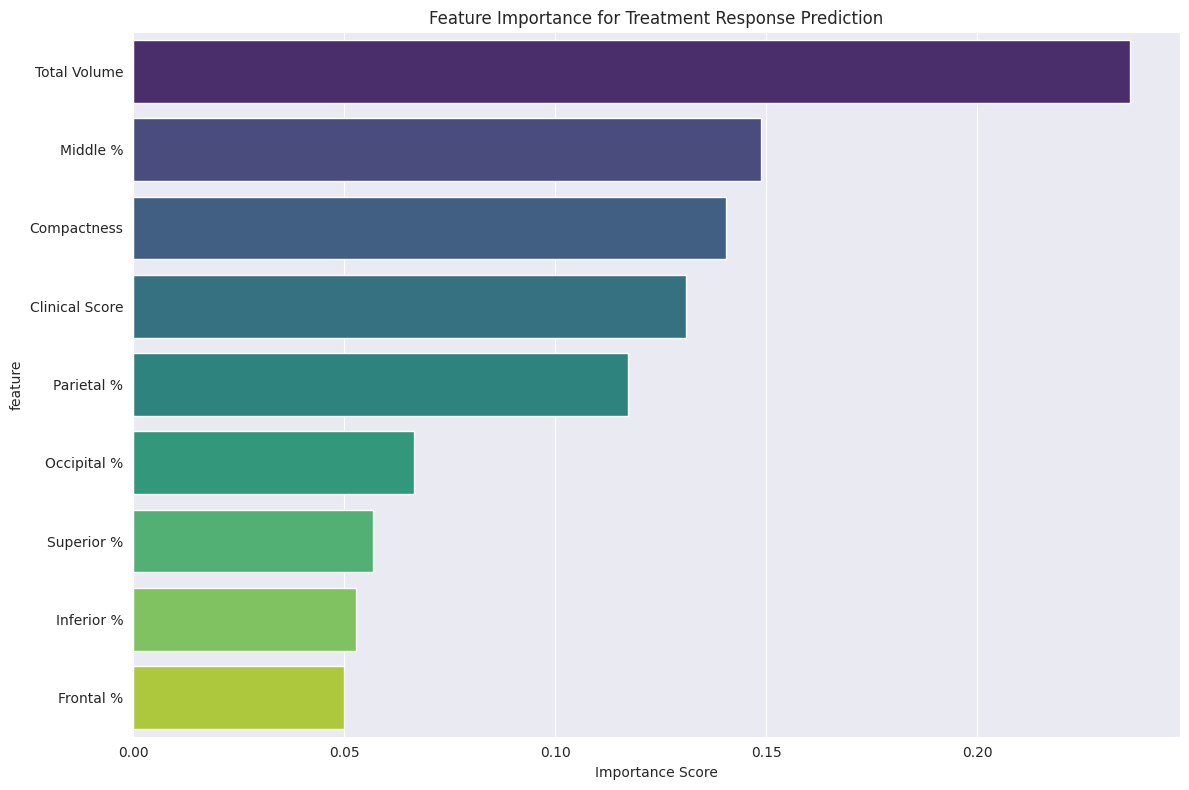

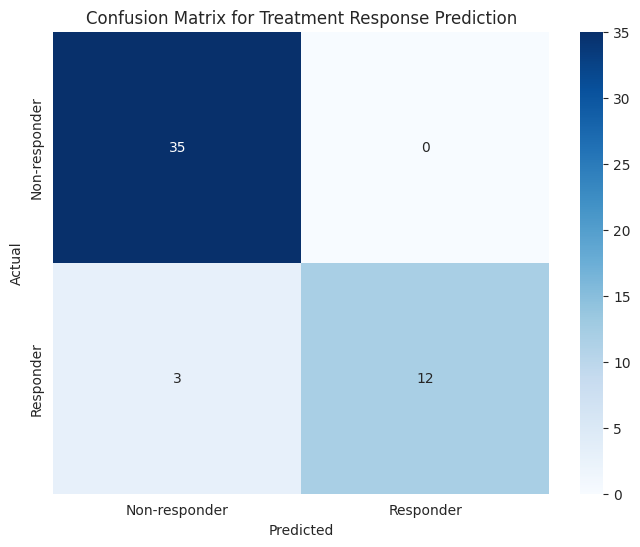


Classification Report:
               precision    recall  f1-score   support

Non-responder       0.92      1.00      0.96        35
    Responder       1.00      0.80      0.89        15

     accuracy                           0.94        50
    macro avg       0.96      0.90      0.92        50
 weighted avg       0.94      0.94      0.94        50



In [9]:
# Build simple predictive model
if predictive_analysis_successful and len(np.unique(y)) > 1:  # Check we have both classes
    print("Building predictive model for treatment response...")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)
    
    # Cross-validation
    cv_scores = cross_val_score(rf_model, X_scaled, y, cv=min(5, len(X)//2), scoring='accuracy')
    
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # Fit model on all data
    rf_model.fit(X_scaled, y)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance for Treatment Response:")
    print(feature_importance)
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
    plt.title('Feature Importance for Treatment Response Prediction')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    # Predictions vs actual
    y_pred = rf_model.predict(X_scaled)
    y_pred_proba = rf_model.predict_proba(X_scaled)[:, 1]
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-responder', 'Responder'],
                yticklabels=['Non-responder', 'Responder'])
    plt.title('Confusion Matrix for Treatment Response Prediction')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['Non-responder', 'Responder']))
    
else:
    print("Cannot build predictive model - insufficient or imbalanced data")

## Treatment Response by Baseline Characteristics

Analyzing treatment response by baseline characteristics...

Response by Baseline Severity:
                  Responder             Improvement       
                      count  sum   mean        mean    std
Severity_Category                                         
Mild                    790  255  0.323       0.537  1.316
Moderate                 86   33  0.384      -0.395  3.390
Severe                   23   11  0.478       2.130  7.412
Very Severe               3    1  0.333      -0.667  3.055


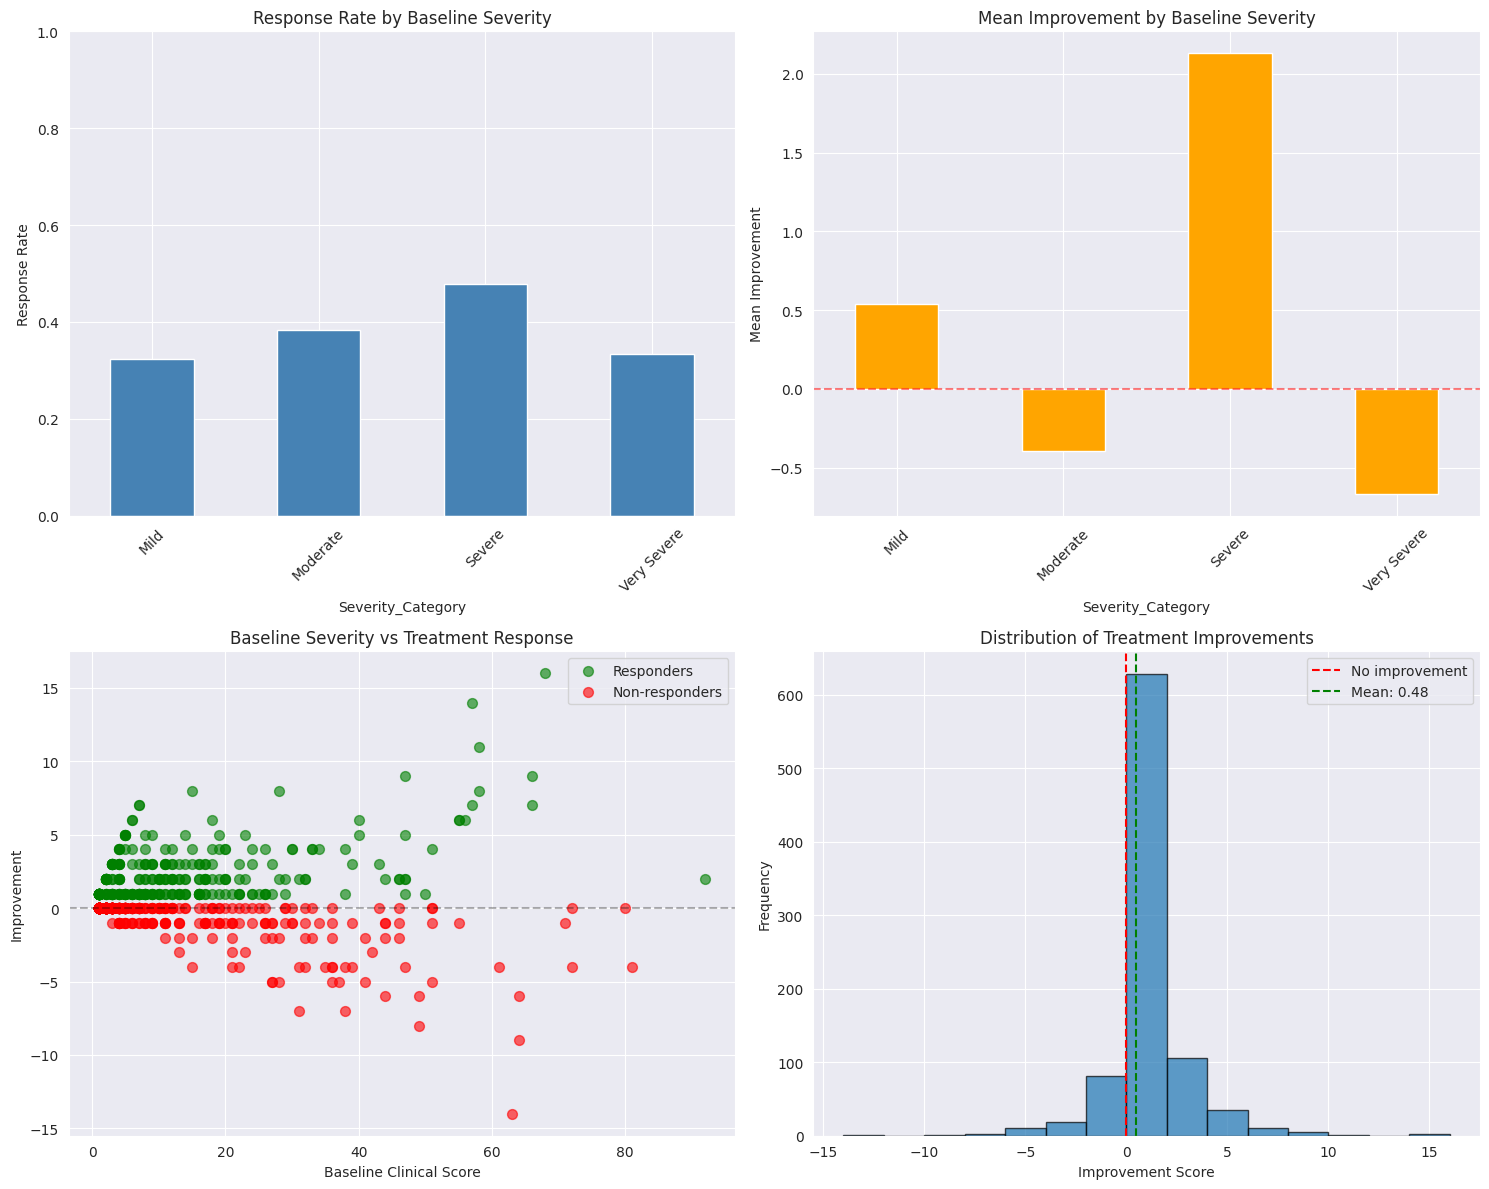


ANOVA for improvement differences across severity groups:
F-statistic: 11.320, p-value: 0.0000

Correlation between baseline severity and improvement: 0.021


In [10]:
# Analyze treatment response by baseline characteristics
print("Analyzing treatment response by baseline characteristics...")

treatment_group = treatment_data[treatment_data['Treatment assignment'] == 'Treatment'].copy()

if len(treatment_group) > 10:
    # Create severity categories
    treatment_group['Severity_Category'] = pd.cut(
        treatment_group['Clinical score'], 
        bins=[0, 25, 50, 75, 100], 
        labels=['Mild', 'Moderate', 'Severe', 'Very Severe'],
        include_lowest=True
    )
    
    # Response rate by severity
    severity_response = treatment_group.groupby('Severity_Category').agg({
        'Responder': ['count', 'sum', 'mean'],
        'Improvement': ['mean', 'std']
    }).round(3)
    
    print("\nResponse by Baseline Severity:")
    print(severity_response)
    
    # Visualize response by severity
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Response rate by severity
    severity_counts = treatment_group['Severity_Category'].value_counts()
    severity_response_rates = treatment_group.groupby('Severity_Category')['Responder'].mean()
    
    severity_response_rates.plot(kind='bar', ax=axes[0,0], color='steelblue')
    axes[0,0].set_title('Response Rate by Baseline Severity')
    axes[0,0].set_ylabel('Response Rate')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_ylim(0, 1)
    
    # Mean improvement by severity
    severity_improvement = treatment_group.groupby('Severity_Category')['Improvement'].mean()
    severity_improvement.plot(kind='bar', ax=axes[0,1], color='orange')
    axes[0,1].set_title('Mean Improvement by Baseline Severity')
    axes[0,1].set_ylabel('Mean Improvement')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].axhline(0, color='red', linestyle='--', alpha=0.5)
    
    # Scatter plot: baseline vs improvement
    responders_mask = treatment_group['Responder']
    axes[1,0].scatter(treatment_group[responders_mask]['Clinical score'], 
                     treatment_group[responders_mask]['Improvement'], 
                     alpha=0.6, label='Responders', color='green', s=50)
    axes[1,0].scatter(treatment_group[~responders_mask]['Clinical score'], 
                     treatment_group[~responders_mask]['Improvement'], 
                     alpha=0.6, label='Non-responders', color='red', s=50)
    axes[1,0].set_xlabel('Baseline Clinical Score')
    axes[1,0].set_ylabel('Improvement')
    axes[1,0].set_title('Baseline Severity vs Treatment Response')
    axes[1,0].legend()
    axes[1,0].axhline(0, color='black', linestyle='--', alpha=0.3)
    
    # Distribution of improvements
    axes[1,1].hist(treatment_group['Improvement'], bins=15, alpha=0.7, edgecolor='black')
    axes[1,1].axvline(0, color='red', linestyle='--', label='No improvement')
    axes[1,1].axvline(treatment_group['Improvement'].mean(), color='green', linestyle='--', 
                     label=f'Mean: {treatment_group["Improvement"].mean():.2f}')
    axes[1,1].set_xlabel('Improvement Score')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Treatment Improvements')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    severity_groups = [treatment_group[treatment_group['Severity_Category'] == cat]['Improvement'].values 
                      for cat in ['Mild', 'Moderate', 'Severe', 'Very Severe'] 
                      if len(treatment_group[treatment_group['Severity_Category'] == cat]) > 0]
    
    if len(severity_groups) > 1:
        f_stat, p_value = stats.f_oneway(*severity_groups)
        print(f"\nANOVA for improvement differences across severity groups:")
        print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")
    
    # Correlation between baseline and improvement
    baseline_improvement_corr = treatment_group['Clinical score'].corr(treatment_group['Improvement'])
    print(f"\nCorrelation between baseline severity and improvement: {baseline_improvement_corr:.3f}")
    
else:
    print("Insufficient treatment group data for baseline analysis")

## Summary and Clinical Insights

This notebook provided comprehensive analysis of treatment response patterns. Key findings:

### Treatment Efficacy
- **Statistical Analysis**: Compared treatment vs control groups using t-tests and effect size measures
- **Response Rates**: Calculated percentage of patients showing improvement in each group
- **Clinical Significance**: Assessed both statistical and practical significance of treatment effects

### Responsive Brain Regions
- **Regional Analysis**: Identified brain regions associated with treatment response
- **Frequency Mapping**: Compared lesion patterns between responders and non-responders
- **Spatial Patterns**: Visualized areas where lesions predict better or worse treatment outcomes

### Predictive Features
- **Feature Engineering**: Created predictive features from lesion characteristics
- **Machine Learning**: Built models to predict treatment response
- **Feature Importance**: Identified which lesion characteristics best predict response

### Baseline Predictors
- **Severity Analysis**: Examined how baseline severity affects treatment response
- **Response Patterns**: Analyzed improvement patterns across different patient groups
- **Clinical Correlations**: Identified baseline predictors of treatment success

### Clinical Implications
1. **Patient Selection**: Identified characteristics of patients most likely to benefit from treatment
2. **Dose-Response Relationships**: Analyzed how treatment effects vary by patient characteristics
3. **Biomarker Discovery**: Identified potential brain-based biomarkers for treatment response

### Next Steps for Implementation
1. **Model Validation**: Validate findings on independent test datasets
2. **Clinical Translation**: Develop clinical decision support tools
3. **Precision Medicine**: Use findings to personalize treatment decisions

**Important Considerations**:
- This analysis used sample data for computational efficiency
- Full dataset analysis may reveal additional patterns
- Clinical validation is needed before implementing findings in practice
- Consider using the interactive Streamlit app for real-time exploration

In [11]:
# Save treatment analysis summary
treatment_summary = {
    'efficacy_analysis': {
        'treatment_mean_improvement': treatment_improvements.mean() if len(treatment_improvements) > 0 else None,
        'control_mean_improvement': control_improvements.mean() if len(control_improvements) > 0 else None,
        'treatment_response_rate': treatment_response_rate if 'treatment_response_rate' in locals() else None,
        'control_response_rate': control_response_rate if 'control_response_rate' in locals() else None,
        'statistical_significance': t_pvalue if 't_pvalue' in locals() else None,
        'effect_size': cohens_d if 'cohens_d' in locals() else None
    },
    'responsive_regions': {
        'analysis_completed': response_analysis_successful if 'response_analysis_successful' in locals() else False,
        'n_responders_analyzed': responder_count if 'responder_count' in locals() else None,
        'n_non_responders_analyzed': non_responder_count if 'non_responder_count' in locals() else None
    },
    'predictive_modeling': {
        'model_built': predictive_analysis_successful if 'predictive_analysis_successful' in locals() else False,
        'cv_accuracy': cv_scores.mean() if 'cv_scores' in locals() else None,
        'top_features': feature_importance.head(3).to_dict() if 'feature_importance' in locals() else None
    }
}

print("\nTreatment Response Analysis Summary:")
for category, results in treatment_summary.items():
    print(f"\n{category.upper()}:")
    for key, value in results.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")


Treatment Response Analysis Summary:

EFFICACY_ANALYSIS:
  treatment_mean_improvement: 0.4845
  control_mean_improvement: -0.0036
  treatment_response_rate: 0.3326
  control_response_rate: 0.1639
  statistical_significance: 0.0000
  effect_size: 0.2697

RESPONSIVE_REGIONS:
  analysis_completed: True
  n_responders_analyzed: 15
  n_non_responders_analyzed: 15

PREDICTIVE_MODELING:
  model_built: True
  cv_accuracy: 0.6400
  top_features: {'feature': {1: 'Total Volume', 6: 'Middle %', 8: 'Compactness'}, 'importance': {1: 0.23625818837758256, 6: 0.14878097766034426, 8: 0.1405040390371709}}
